# 🩺 Check Me — Self-Screening Risk Triage: Training Notebook (with SMOTE)


#### Imports & Configuration

In [34]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve
)
from sklearn.utils import class_weight
import xgboost as xgb

# sns.set_theme(style='whitegrid', palette='muted')
# plt.rcParams.update({'figure.dpi': 100, 'axes.titlesize': 13})

RANDOM_STATE = 42
DATA_PATH    = 'synthetic_breast_cancer_risk.csv'
# DATA_PATH_2  = 'synthetic_breast_cancer_dataset.csv'
MODEL_PATH   = 'model.joblib'

# Label mapping (used throughout)
LABEL_NAMES = {0: 'Green', 1: 'Yellow', 2: 'Red'}
LABEL_COLORS = {'Green': '#2ecc71', 'Yellow': '#f39c12', 'Red': '#e74c3c'}




#### Load Dataset

In [35]:
df = pd.read_csv(DATA_PATH)
print(f'Shape: {df.shape}')
df.head()

Shape: (5000, 13)


,age,family_history,previous_lumps,breast_pain,nipple_discharge,skin_dimples,lump_size_mm,symptom_duration_days,pregnancy_status,hormonal_contraception,region,language,risk_level
0,43,0,0,0,0,0,NaN,0,0,0,Western Province,English,0
1,30,0,0,0,0,0,NaN,0,0,0,Southern Province,Kinyarwanda,0
2,49,0,0,0,0,0,NaN,0,0,1,Western Province,English,0
3,30,1,0,0,0,0,NaN,0,0,0,Eastern Province,English,0
4,43,0,0,0,0,0,NaN,0,0,1,Northern Province,English,0


In [36]:
df.rename(columns={'cancer_label': 'risk_level'}, inplace=True)   

In [37]:
# Basic info & missing-value counts
df.info()
print('\nMissing values per column:')
print(df.isnull().sum()[df.isnull().sum() > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     5000 non-null   int64  
 1   family_history          5000 non-null   int64  
 2   previous_lumps          5000 non-null   int64  
 3   breast_pain             5000 non-null   int64  
 4   nipple_discharge        5000 non-null   int64  
 5   skin_dimples            5000 non-null   int64  
 6   lump_size_mm            935 non-null    float64
 7   symptom_duration_days   5000 non-null   int64  
 8   pregnancy_status        5000 non-null   int64  
 9   hormonal_contraception  5000 non-null   int64  
 10  region                  5000 non-null   object 
 11  language                5000 non-null   object 
 12  risk_level              5000 non-null   int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 507.9+ KB

Missing values per column:
lump_

In [38]:
#plot ditstribution of classes
label_map = {0: 'Green', 1: 'Yellow', 2: 'Red'}  
counts = df['risk_level'].value_counts().sort_index()
try:
    counts.index = [label_map[i] for i in counts.index]
except KeyError:
    pass  
# label_map
counts

Green     3947
Yellow     898
Red        155
Name: count, dtype: int64

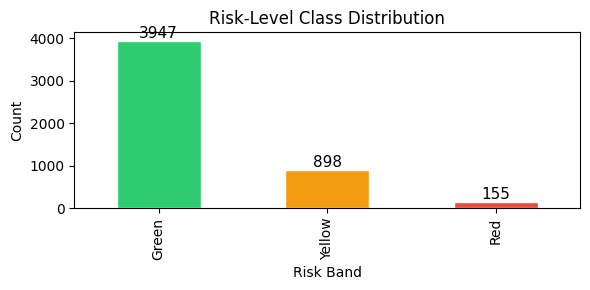

In [39]:
#plot distribution of classes

ax = counts.plot(kind='bar', color=[LABEL_COLORS.get(l, '#999') for l in counts.index],
                 edgecolor='white', figsize=(6, 3))
ax.set_title('Risk-Level Class Distribution')
ax.set_xlabel('Risk Band')
ax.set_ylabel('Count')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

The data seems to be heavily imbalanced, with most patients being assigned to the green category. We need to address this issue because it can lead to biased models that perform well on the majority class but fail to detect the minority class. hence we need to use a oversampling technique to balance the data. And probably use a different metric to evaluate the model like the F1 score and recall because precision is not a good metric for imbalanced data therefore we will not focus on accuracy values to evaluate the model.


#### Exploratory Data Analysis (EDA)

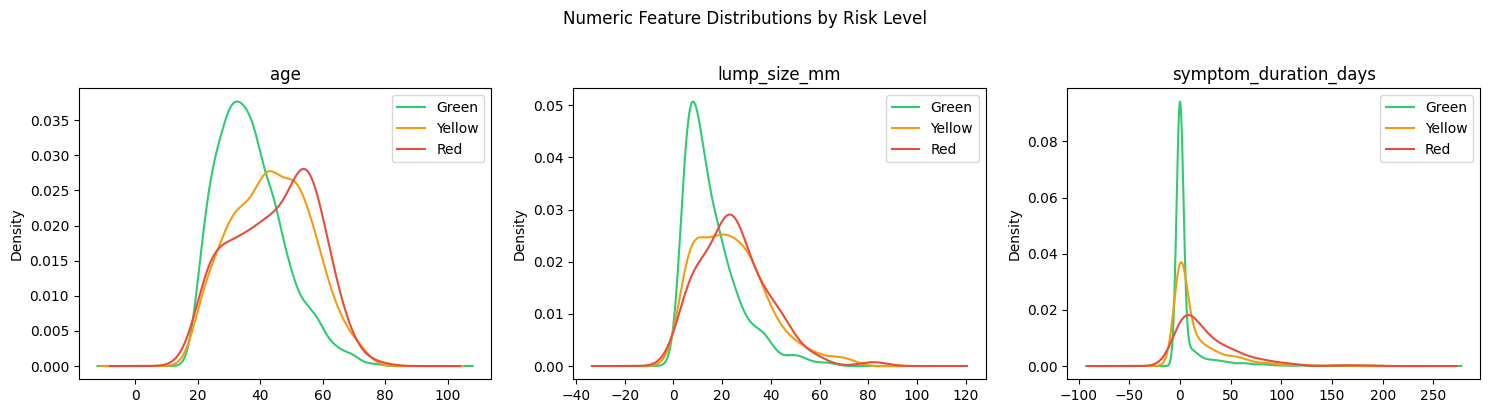

In [40]:
# For every value of risk level, how much does it affect the numeric features?
numeric_cols = ['age', 'lump_size_mm', 'symptom_duration_days']
fig, axes = plt.subplots(1, len(numeric_cols), figsize=(15, 4))

for ax, col in zip(axes, numeric_cols):
    for lvl, grp in df.groupby('risk_level'):
        label = label_map.get(lvl, str(lvl))
        grp[col].dropna().plot.kde(ax=ax, label=label, color=LABEL_COLORS.get(label))
    ax.set_title(col)
    ax.legend()

plt.suptitle('Numeric Feature Distributions by Risk Level', y=1.02)
plt.tight_layout()
plt.show()

This numeric feature distribution helps us identify features that we can use to separate the risk levels. for example old age and larger lamps are correlated with higher risk levels. Unlike symptom days which basically overlaps for all the risk levels, and hence shows that it is really not that useful hence we can remove it to save computational power.

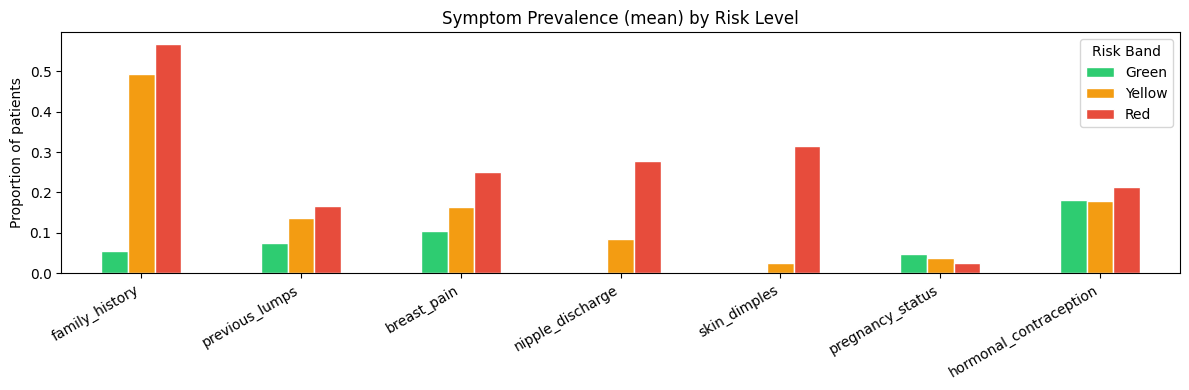

In [41]:
# checking binary features and how their values differ by risk level
binary_cols = ['family_history', 'previous_lumps', 'breast_pain',
               'nipple_discharge', 'skin_dimples', 'pregnancy_status',
               'hormonal_contraception']

prevalence = (
    df.groupby('risk_level')[binary_cols]
      .mean()
      .rename(index=label_map)
      .T
)

prevalence.plot(kind='bar', figsize=(12, 4),
                color=[LABEL_COLORS.get(c, '#999') for c in prevalence.columns],
                edgecolor='white')
plt.title('Symptom Prevalence (mean) by Risk Level')
plt.ylabel('Proportion of patients')
plt.xticks(rotation=30, ha='right')
plt.legend(title='Risk Band')
plt.tight_layout()
plt.show()

Similar to the previous cell, we looked at identifying the most important features for our model. Here we see skin dimples as the most important feature, together with nipple discharge, lump size and family history.

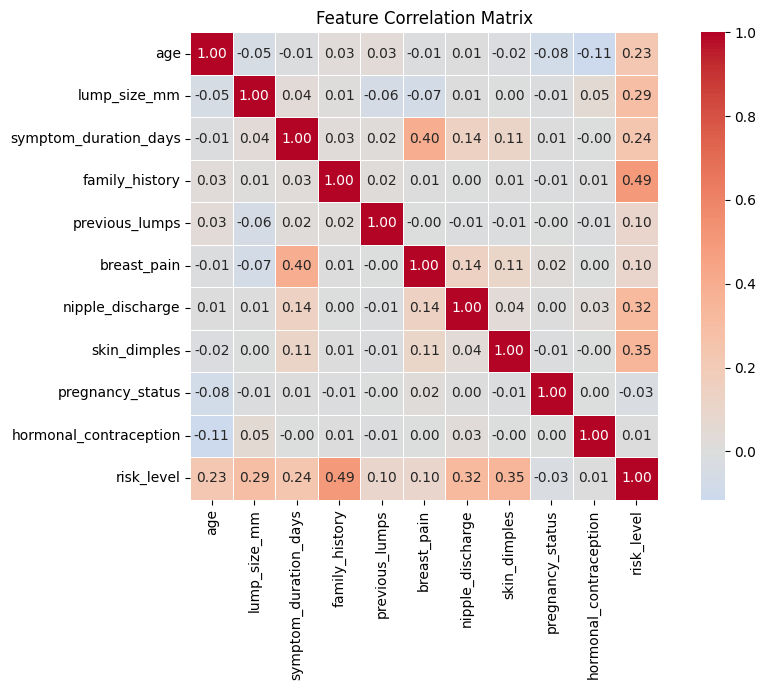

In [42]:
#check how much each feature correlates with risk level
heat_cols = numeric_cols + binary_cols + ['risk_level']
corr = df[heat_cols].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            linewidths=0.5, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Here we are looking to eliminate redundancy in our features, by looking at highlt correlated features we can remove one of the two to save computational power. Low correlation is 0.4 and below, High correlation is 0.85 and above. Most features are lowly correlated which shows they allcapture some kind of information towards the target variable.

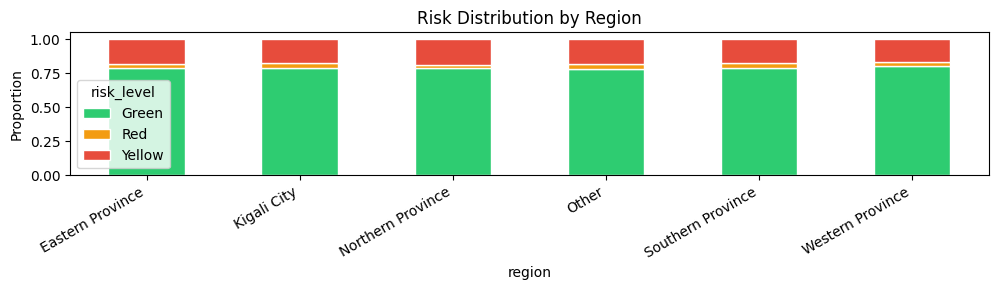

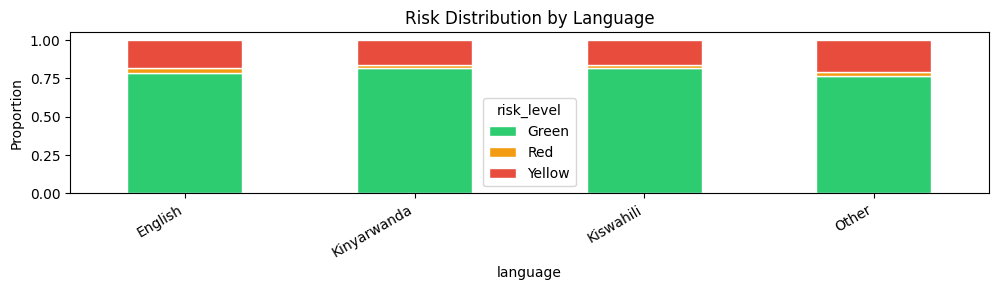

In [43]:
#look for anything interesting in the region and language columns
for cat_col in ['region', 'language']:
    if cat_col in df.columns:
        pd.crosstab(df[cat_col], df['risk_level'].map(label_map),
                    normalize='index').plot(kind='bar', stacked=True,
                                           color=[LABEL_COLORS[l] for l in ['Green', 'Yellow', 'Red']],
                                           figsize=(10, 3), edgecolor='white')
        plt.title(f'Risk Distribution by {cat_col.capitalize()}')
        plt.ylabel('Proportion')
        plt.xticks(rotation=30, ha='right')
        plt.tight_layout()
        plt.show()

Looking at the categorical features, the  most important takeaway is that the ratio of Green/Yellow/Red remains almost constant across every Region and every Language. Since these are not teliing us any information, we should probably exclude them from the model during training.


#### Preprocessing Pipeline

In [44]:
#lets define the required features and perform train test split
X = df.drop(columns=['risk_level'])
y = df['risk_level']

numeric_features     = ['age', 'lump_size_mm', 'symptom_duration_days']
# categorical_features = ['region', 'language']
binary_features      = ['family_history', 'previous_lumps', 'breast_pain',
                         'nipple_discharge', 'skin_dimples',
                         'pregnancy_status', 'hormonal_contraception']

#build pipeline
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# categorical_transformer = Pipeline([
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer,     numeric_features),
    # ('cat', categorical_transformer, categorical_features),
    ('bin', 'passthrough',           binary_features)
])

# Train / test split (stratified) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f'Train: {X_train.shape},  Test: {X_test.shape}')
print(f'Class counts (train): {y_train.value_counts().to_dict()}')

Train: (4000, 12),  Test: (1000, 12)
Class counts (train): {0: 3158, 1: 718, 2: 124}


In [45]:
# Using SMOTE within the pipelines for class balancing instead of sample weights.
print('SMOTE will be used for class balancing in the models.')

SMOTE will be used for class balancing in the models.


Given we have an inbalanced dataset, we are going give weights to the classes in order to balance the dataset. here is the distribution of the classes: green (0.422), yellow (1.0), red (10.753). So a red class will be almost 10 yellow and even more green ones.


#### Baseline Model: Logistic Regression

In [46]:
#lets try a baseline model and see how it performs 
LR_C          = 1.0         # Regularisation strength (smaller = stronger)
LR_SOLVER     = 'lbfgs'     # 'lbfgs', 'saga', 'newton-cg'
LR_MAX_ITER   = 1000

baseline_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', LogisticRegression(
        C=LR_C, solver=LR_SOLVER, max_iter=LR_MAX_ITER,
        random_state=RANDOM_STATE
    ))
])

baseline_pipe.fit(X_train, y_train)
print('Baseline model trained ')

Baseline model trained 


In [47]:
# Cross-validation given we dont have alot of data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(baseline_pipe, X_train, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
print(f'Logistic Regression 5-Fold F1 (weighted): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}')

Logistic Regression 5-Fold F1 (weighted): 0.8283 ± 0.0181


Given we have a small dataset, we choose to use cross validation of 5 folds which is like training on the dataset 5 times with different data, Acoording to the results we see over 0.83  performance which is derived from recall and precision being weighted. Again, we cant rely on accuracy since we have an imbalance dataset.

#### Try random forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

# --- RF Hyperparameters ---
RF_ESTIMATORS = 100
RF_MAX_DEPTH  = None      # Allow trees to grow until pure
RF_MIN_SAMPLES = 2        # Minimum samples required to split a node

rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=RF_ESTIMATORS,
        max_depth=RF_MAX_DEPTH,
        min_samples_split=RF_MIN_SAMPLES,
        class_weight='balanced', # Automatically handles the Red/Green imbalance
        random_state=RANDOM_STATE,
        n_jobs=-1                # Use all CPU cores for speed
    ))
])

rf_pipe.fit(X_train, y_train)
print('Random Forest baseline model trained')

Random Forest baseline model trained



#### Improved Model: XGBoost

In [49]:
# # we try another well reputed model
# XGB_PARAMS = dict(
#     objective        = 'multi:softprob',
#     num_class        = 3,
#     eval_metric      = 'mlogloss',
#     n_estimators     = 300,        # try 100–500
#     max_depth        = 5,          # try 3–8
#     learning_rate    = 0.05,       # try 0.01–0.2
#     subsample        = 0.8,
#     colsample_bytree = 0.8,
#     random_state     = RANDOM_STATE,
#     verbosity        = 0
# )

# xgb_pipe = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier',   xgb.XGBClassifier(**XGB_PARAMS))
# ])

# xgb_pipe.fit(X_train, y_train, classifier__sample_weight=sample_weights)
# print('XGBoost model trained ')

In [50]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# 1. Define the search space using the 'stepname__parameter' syntax
param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [3, 4, 5, 6, 8],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 0.9],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9],
}

# 2. Re-use your pipeline structure
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE,
        verbosity=0
    ))
])

# 3. Setup the Search (AutoML behavior)
# n_iter=15 means it will try 15 random combinations from your grid
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_distributions,
    n_iter=15, 
    cv=cv,             # Using your StratifiedKFold
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

# 4. Fit using your sample_weights
# Note: we pass weights specifically to the 'classifier' step
xgb_search.fit(
    X_train, y_train, 
    # classifier__sample_weight=sample_weights
)

# 5. Extract results
print(f'Best XGBoost F1 Score: {xgb_search.best_score_:.4f}')
print(f'Best Parameters: {xgb_search.best_params_}')

# Save the best version for final evaluation
best_xgb_pipe = xgb_search.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best XGBoost F1 Score: 0.8718
Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.7}



#### Evaluation & Threshold Tuning


  Logistic Regression (Baseline)
              precision    recall  f1-score   support

       Green       0.95      0.87      0.91       789
      Yellow       0.51      0.64      0.57       180
         Red       0.45      0.77      0.57        31

    accuracy                           0.83      1000
   macro avg       0.64      0.76      0.68      1000
weighted avg       0.86      0.83      0.84      1000

ROC-AUC (weighted OvR): 0.9272


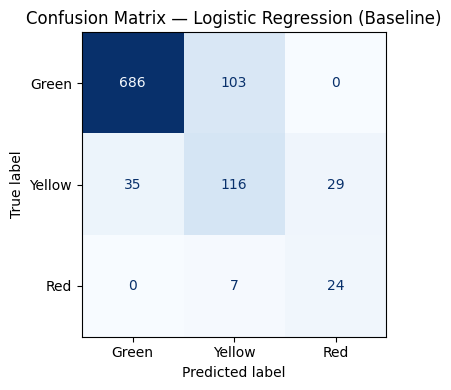


  Random Forest Baseline
              precision    recall  f1-score   support

       Green       0.94      0.91      0.93       789
      Yellow       0.59      0.66      0.62       180
         Red       0.53      0.52      0.52        31

    accuracy                           0.85      1000
   macro avg       0.69      0.70      0.69      1000
weighted avg       0.86      0.85      0.86      1000

ROC-AUC (weighted OvR): 0.9361


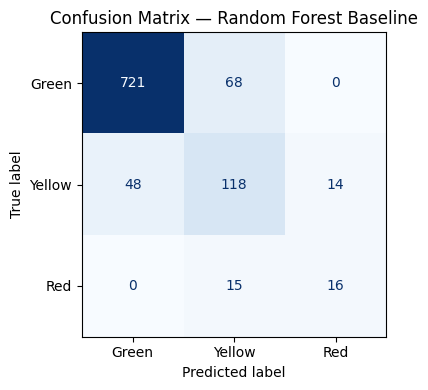


  Tuned XGBoost (AutoML)
              precision    recall  f1-score   support

       Green       0.92      0.95      0.94       789
      Yellow       0.67      0.61      0.64       180
         Red       0.67      0.45      0.54        31

    accuracy                           0.88      1000
   macro avg       0.75      0.67      0.70      1000
weighted avg       0.87      0.88      0.87      1000

ROC-AUC (weighted OvR): 0.9526


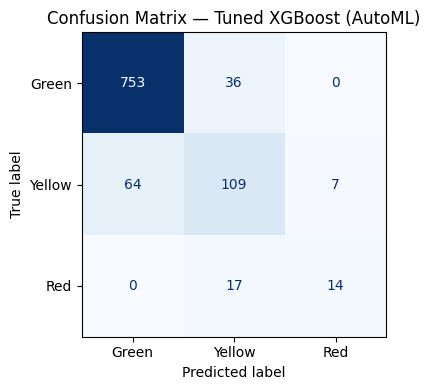

In [51]:
#compare both models
def evaluate(model, X_test, y_test, name='Model'):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)

    print(f'\n{'='*50}')
    print(f'  {name}')
    print('='*50)
    print(classification_report(y_test, y_pred,
                                target_names=['Green', 'Yellow', 'Red']))

    roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
    print(f'ROC-AUC (weighted OvR): {roc_auc:.4f}')

    # Confusion matrix
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels=['Green', 'Yellow', 'Red']
    ).plot(ax=ax, colorbar=False, cmap='Blues')
    ax.set_title(f'Confusion Matrix — {name}')
    plt.tight_layout()
    plt.show()

    return y_pred, y_prob

lr_pred, lr_prob = evaluate(baseline_pipe, X_test, y_test, 'Logistic Regression (Baseline)')
rf_pred, rf_prob  = evaluate(rf_pipe,       X_test, y_test, 'Random Forest Baseline')
xgb_pred, xgb_prob = evaluate(xgb_search.best_estimator_, X_test, y_test, 'Tuned XGBoost (AutoML)')
# lr_pred, lr_prob   = evaluate(baseline_pipe, X_test, y_test, 'Logistic Regression (Balanced)')
# xgb_pred_, xgb_prob = evaluate(xgb_pipe,      X_test, y_test, 'XGBoost (Balanced)')


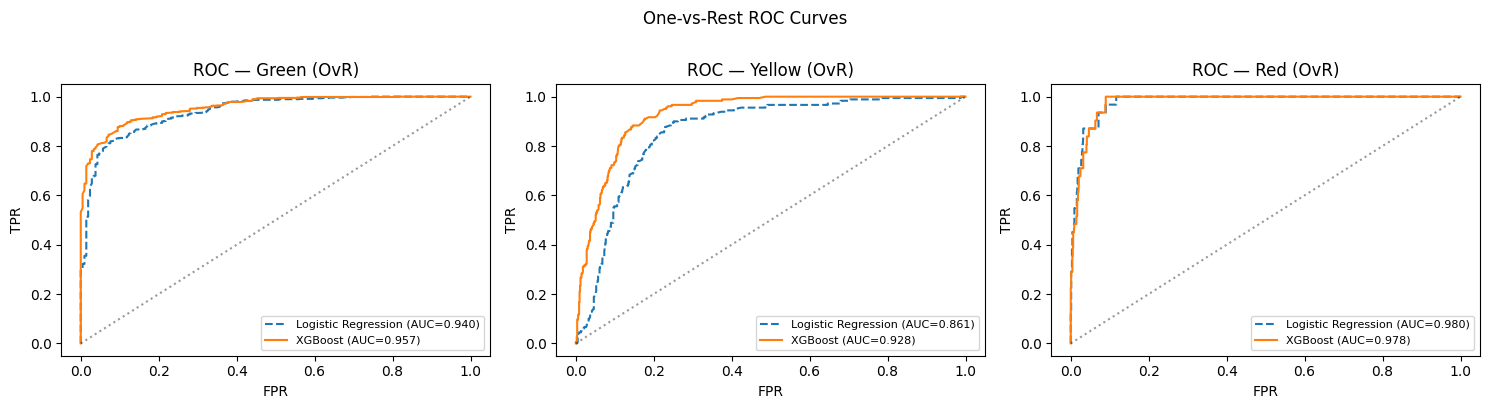

In [52]:
# plot the AUC
n_classes = 3
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

fig, axes = plt.subplots(1, n_classes, figsize=(15, 4))
for i, (cls_name, color) in enumerate(LABEL_COLORS.items()):
    for probs, model_name, ls in [
        (lr_prob,  'Logistic Regression', '--'),
        (xgb_prob, 'XGBoost',             '-')
    ]:
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
        auc_score   = auc(fpr, tpr)
        axes[i].plot(fpr, tpr, ls=ls, label=f'{model_name} (AUC={auc_score:.3f})')

    axes[i].plot([0, 1], [0, 1], 'k:', alpha=0.4)
    axes[i].set_title(f'ROC — {cls_name} (OvR)')
    axes[i].set_xlabel('FPR');  axes[i].set_ylabel('TPR')
    axes[i].legend(fontsize=8)

plt.suptitle('One-vs-Rest ROC Curves', y=1.01)
plt.tight_layout()
plt.show()

Logistic regression on these one vs all curves has a higher AUC which means it is performing better given we have a small dataset. XGBoost would probably perform better on larger datasets.

In [53]:
# #   TWEAK ME: Red-class threshold tuning 
# # Healthcare rule: maximise Recall for 'Red' (high risk).
# # Lower the threshold → more Red predictions → higher Recall but lower Precision.

# RED_IDX = 2  # class index for 'Red'

# precisions, recalls, thresholds = precision_recall_curve(
#     (y_test == RED_IDX).astype(int), xgb_prob[:, RED_IDX]
# )

# fig, ax = plt.subplots(figsize=(8, 4))
# ax.plot(thresholds, precisions[:-1], label='Precision (Red)', color='steelblue')
# ax.plot(thresholds, recalls[:-1],    label='Recall (Red)',    color='tomato')
# ax.axvline(x=0.35, color='gray', ls='--', alpha=0.7, label='Example threshold = 0.35')
# ax.set_xlabel('Decision Threshold for Red')
# ax.set_ylabel('Score')
# ax.set_title('Precision-Recall vs Threshold for Red Class (XGBoost)')
# ax.legend()
# plt.tight_layout()
# plt.show()

In [54]:
# #  Apply custom thresholds & reassign risk bands 
# #  TWEAK these to adjust sensitivity/specificity:
# RED_THRESHOLD    = 0.35   # P(Red) >= this → Red
# YELLOW_THRESHOLD = 0.30   # P(Yellow) >= this (and not Red) → Yellow

# def apply_thresholds(proba, red_thresh=RED_THRESHOLD, yellow_thresh=YELLOW_THRESHOLD):
#     """Convert probability matrix to risk-band labels with custom thresholds."""
#     labels = []
#     for row in proba:
#         if row[2] >= red_thresh:
#             labels.append(2)   # Red
#         elif row[1] >= yellow_thresh:
#             labels.append(1)   # Yellow
#         else:
#             labels.append(0)   # Green
#     return np.array(labels)

# xgb_pred_custom = apply_thresholds(xgb_prob)
# print('Custom-threshold classification report (XGBoost):')
# print(classification_report(y_test, xgb_pred_custom,
#                              target_names=['Green', 'Yellow', 'Red']))


#### Interpretability: SHAP

In [55]:
# 1. Get feature names simply (since you only have numeric/binary)
all_feature_names = numeric_features + binary_features

# 2. Get the fitted classifier from the pipe (or the tuned search)
# If using the tuned model from earlier, use xgb_search.best_estimator_
model_step = baseline_pipe.named_steps['classifier']
preproc_step = baseline_pipe.named_steps['preprocessor']

# 3. Transform training subset for SHAP
X_train_t = preproc_step.transform(X_train.iloc[:500])

# 4. SHAP explainer
explainer = shap.Explainer(model_step, X_train_t)
shap_values = explainer(X_train_t)

# print(f'SHAP values computed {shap_values}')
print(f'SHAP output shape: {shap_values.values.shape}')

SHAP output shape: (500, 10, 3)


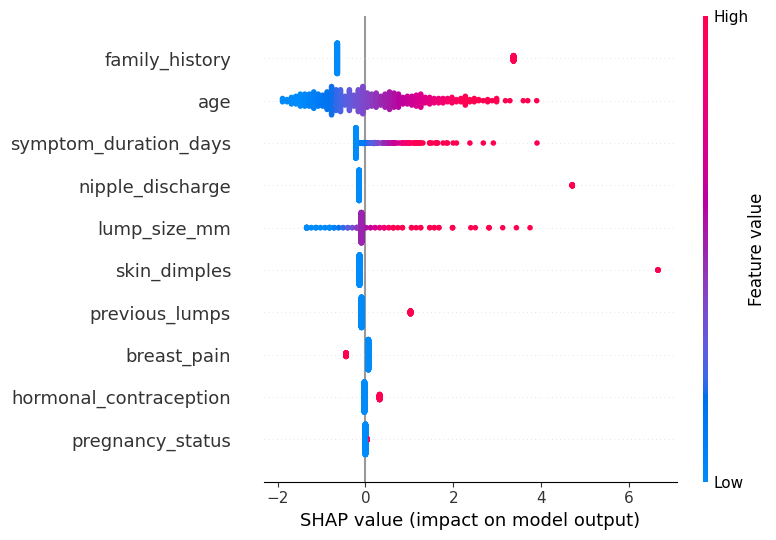

In [56]:
# ── SHAP Summary Plot — Red class (most safety-critical) ─────────────────────
shap.summary_plot(
    shap_values.values[:, :, 2],   # SHAP values for Red
    X_train_t,
    feature_names=all_feature_names,
    show=True,
    max_display=10
)

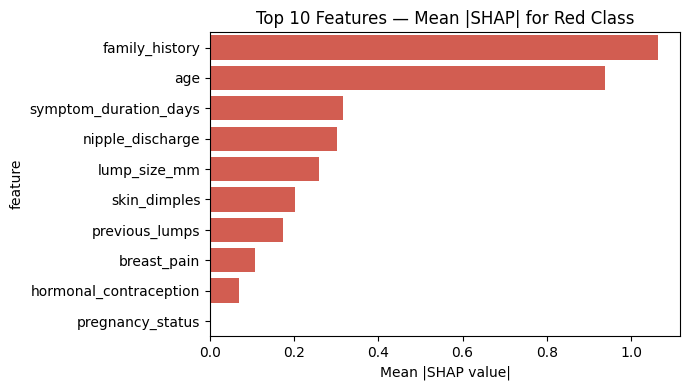


Top 5 risk drivers (Red class):
  family_history: 1.0633
  age: 0.9382
  symptom_duration_days: 0.3168
  nipple_discharge: 0.3010
  lump_size_mm: 0.2580


In [57]:
# ── Mean |SHAP| — top-5 global drivers for Red ───────────────────────────────
mean_shap = np.abs(shap_values.values[:, :, 2]).mean(axis=0)
importance_df = pd.DataFrame({'feature': all_feature_names, 'mean_shap': mean_shap})
importance_df = importance_df.sort_values('mean_shap', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(data=importance_df, y='feature', x='mean_shap', ax=ax, color='#e74c3c')
ax.set_title('Top 10 Features — Mean |SHAP| for Red Class')
ax.set_xlabel('Mean |SHAP value|')
plt.tight_layout()
plt.show()

print('\nTop 5 risk drivers (Red class):')
for i, row in importance_df.head(5).iterrows():
    print(f'  {row["feature"]}: {row["mean_shap"]:.4f}')

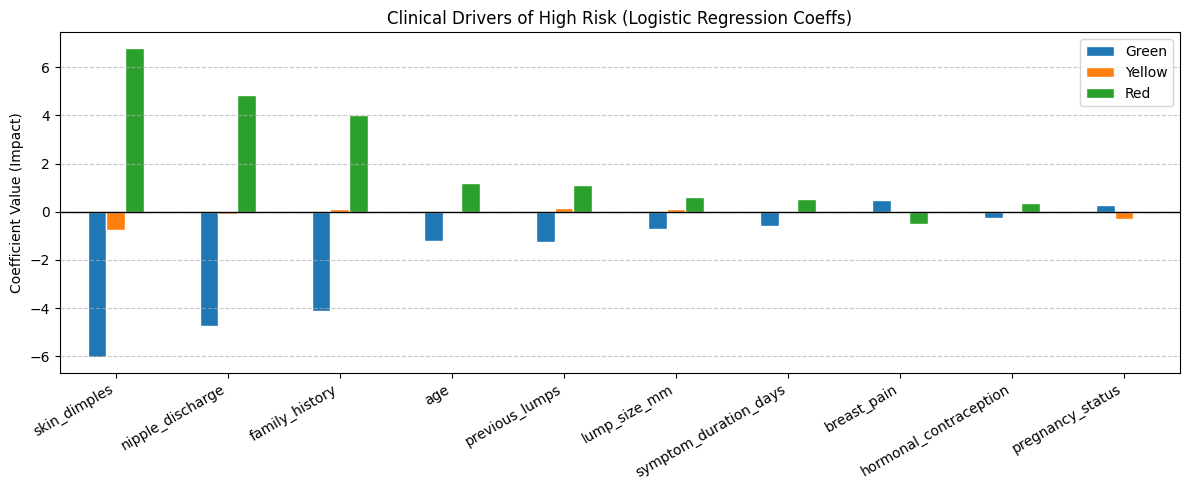

In [58]:
# 1. Access the model and feature names directly
lr_model = baseline_pipe.named_steps['classifier']

# Since no cat features, names are just the sum of your two lists
lr_feature_names = numeric_features + binary_features

# 2. Create the Coefficient DataFrame
# lr_model.coef_ has a shape of (n_classes, n_features)
coef_df = pd.DataFrame(
    lr_model.coef_,
    index=['Green', 'Yellow', 'Red'],
    columns=lr_feature_names
).T

# 3. Sort by the 'Red' class to see what drives High Risk
# We use absolute values to find the strongest predictors (positive or negative)
top_red = coef_df['Red'].abs().nlargest(10).index

# 4. Plotting
coef_df.loc[top_red].plot(kind='bar', figsize=(12, 5), edgecolor='white')
plt.title('Clinical Drivers of High Risk (Logistic Regression Coeffs)')
plt.ylabel('Coefficient Value (Impact)')
plt.axhline(0, color='black', lw=1)
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Save Model

In [59]:
# Save the XGBoost pipeline (best model)
joblib.dump(xgb_pipe, MODEL_PATH)
print(f'Model saved → {MODEL_PATH}')

# Save SHAP summary plot
plt.figure()
shap.summary_plot(shap_values.values[:, :, RED_IDX], X_train_t,
                  feature_names=all_feature_names, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
plt.close()
print('SHAP plot saved → shap_summary.png')

Model saved → model.joblib


NameError: name 'RED_IDX' is not defined

<Figure size 640x480 with 0 Axes>


#### Quick Prediction Demo

Manually craft a sample patient and run it through the pipeline.

In [ ]:
# ──  TWEAK ME: modify patient inputs ───────────────────────────────────────
sample_patient = pd.DataFrame([{
    'age':                    45,
    'family_history':          1,
    'previous_lumps':          1,
    'breast_pain':             0,
    'nipple_discharge':        1,
    'skin_dimples':            0,
    'lump_size_mm':           15.0,
    'symptom_duration_days':  30,
    'pregnancy_status':        0,
    'hormonal_contraception':  1,
    'region':                 'East Africa',
    'language':               'Swahili'
}])

proba  = baseline_pipe.predict_proba(sample_patient)[0]
custom = apply_thresholds(proba.reshape(1, -1))[0]

BAND = {0: ' Green', 1: ' Yellow', 2: ' Red'}
print(f'Class probabilities:  Green={proba[0]:.3f}, Yellow={proba[1]:.3f}, Red={proba[2]:.3f}')
print(f'Risk Band:            {BAND[custom]}')

# Simple recommendation lookup
RECOMMENDATIONS = {
    0: [' Perform monthly self-check', ' Maintain healthy diet & weight',
        ' Stay active (150 min/week)', ' Annual screening reminder'],
    1: ['⏱ Track symptoms for 7–14 days',
        ' Consider booking a screening if symptoms persist',
        ' Prioritise sleep and stress management',
        ' Keep a symptom diary'],
    2: [' **Strongly recommended**: visit a clinic for screening',
        ' Contact your healthcare provider this week',
        ' Bring this summary to your appointment',
        ' This is not a diagnosis — a professional assessment is needed']
}

print('\nRecommendations:')
for r in RECOMMENDATIONS[custom]:
    print(f'  {r}')

print('\n  Disclaimer: This is NOT a diagnosis. Consult a healthcare professional for any concerns.')

Class probabilities:  Green=0.000, Yellow=0.011, Red=0.989
Risk Band:             Red

Recommendations:
   **Strongly recommended**: visit a clinic for screening
   Contact your healthcare provider this week
   Bring this summary to your appointment
   This is not a diagnosis — a professional assessment is needed

  Disclaimer: This is NOT a diagnosis. Consult a healthcare professional for any concerns.
